# Find owners of parcels by categories and plot #

Find category of owners of all parcels with wish list csv file.

# Impot libraries #

In [1]:
import pandas as pd
import geopandas as gpd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

# Defintion of the files #

## Shapefiles Parcelles ##

In [92]:
# Data files
# Shapes of all the parcels

file_NPCS_PARV = "../data/shapefiles/NPCS_CAD_TPR_PARV_S.shp"
file_MOVD_PARV= "../data/shapefiles/MOVD_CAD_TPR_PARV_S.shp"
file_NPCS_DDP = "../data/shapefiles/NPCS_CAD_TPR_DDP_S.shp"
file_MOVD_DDP = "../data/shapefiles/MOVD_CAD_TPR_DDP_S.shp"

## Other data ##

In [93]:
# Data of all communes of Vaud

file_communes_vd = '../data/communes_vd.csv'

# List of parcels with interest of the commune of Mex 

file_whish_list = '../data/mex_whish_list.csv'

# DB connexion #

In [94]:
# Parcels's owners

db_file = '../data/APMK.sqlite'
con = sqlite3.connect(db_file)

# Load parcels data #

In [95]:
# Load shapefile to geodataframe and merge them

parcels_NPCS_PARV = gpd.read_file(file_NPCS_PARV)
parcels_MOVD_PARV = gpd.read_file(file_MOVD_PARV)
parcelles_NPCS_DDP = gpd.read_file(file_NPCS_DDP)
parcelles_MOVD_DDP = gpd.read_file(file_MOVD_DDP)

## Merge parcels dataframe ##

In [96]:
parcels_shape = pd.concat([parcels_NPCS_PARV, parcels_MOVD_PARV])
parcels_shape.reset_index(drop=True, inplace=True)
parcels_ddp_shape = pd.concat([parcelles_NPCS_DDP, parcelles_MOVD_DDP])
parcels_ddp_shape.reset_index(drop=True, inplace=True)
parcels_ddp_shape['no_com'] = parcels_ddp_shape['IDENTDN'].str.slice(stop=6).str.replace('VD0*', '', regex=True)

In [97]:
# cleanup 

parcels_shape = parcels_shape.drop(['VALIDITE_T', 'VALIDITE', 'EGRIS_EGRI', 'ID', 'SHAPE_LEN', 'INTEGRALIT', 'IDENTDN', 'SUPERFICIE', 'SHAPE_AREA', 'GENRE_TXT', 'GENRE'], axis=1)
parcels_ddp_shape = parcels_ddp_shape.drop(['VALIDITE_T', 'VALIDITE', 'EGRIS_EGRI', 'ID', 'SHAPE_LEN', 'INTEGRALIT', 'IDENTDN', 'SUPERFICIE', 'SHAPE_AREA', 'GENRE_TXT', 'GENRE'], axis=1)

# Import data of communes of Vaud #

In [98]:
communes_vd_data = pd.read_csv(file_communes_vd)
# cleanup
communes_vd_data = communes_vd_data[['no_com_can', 'no_com_fed', 'nom_min', 'perimetre']]
communes_vd_data = communes_vd_data.rename(columns={"no_com_can": "no_com", "nom_min": "nom_commune"})
communes_vd_data['nom_commune'] = communes_vd_data['nom_commune'].str.replace(' (VD)', '', regex=False)

## Load whish list of parcels ##

In [99]:
# Load list of parcels sought and add columns

whish_list = pd.read_csv(file_whish_list)

## build IDEX2000 value ##

In [100]:
# Add new columns

whish_list['IDEX2000'] = whish_list['no_com'].map('{:0>3}'.format) + whish_list['no_parc'].map('{:0>6}'.format)
whish_list['IDEX2000'] = np.int64(whish_list['IDEX2000'])
parcels_ddp_shape['IDEX2000'] = parcels_ddp_shape['no_com'].map('{:0>3}'.format) + parcels_ddp_shape['NUMERO'].map('{:0>6}'.format)
parcels_ddp_shape['IDEX2000'] = np.int64(parcels_ddp_shape['IDEX2000'])
# Cleanup
parcels_ddp_shape = parcels_ddp_shape.drop(['no_com'], axis=1)

# Merge both shapes geodataframe #

In [101]:
parcels_shape = pd.concat([parcels_shape, parcels_ddp_shape])

## build ficheID ##

In [103]:
whish_list['fiche_id'] = whish_list['no_com'].map(str) + "." + whish_list['no_parc'].map(str)

## Add column no_com ##

In [104]:
whish_list = pd.merge(whish_list, communes_vd_data, how='left', on='no_com')

## Clean dataframe ##

In [105]:
# Fix values column proprietaire

whish_list.proprietaire = whish_list.proprietaire.str.replace(' [Ll]a [Cc]ommune[, ]*.*', '', regex=True)
whish_list.proprietaire = whish_list.proprietaire.str.replace('St-', 'Saint-', regex=True)
whish_list.proprietaire = whish_list.proprietaire.str.replace('Ste-', 'Sainte-', regex=True)
whish_list.proprietaire = whish_list.proprietaire.str.replace(' s/', '-sur-', regex=True)

## Convert whish_list dataframe to geodataframe ##

In [106]:
# Convert whish_list to Geodataframe

whish_list = gpd.GeoDataFrame(whish_list)
whish_list['geometry'] = None
whish_list = whish_list.set_crs(crs=2056)
whish_list = whish_list.drop(['geometry'], axis=1)
whish_list = pd.merge(whish_list, parcels_shape, how='left', on='IDEX2000')
whish_list = whish_list.drop(['NUMERO'], axis=1)
whish_list['centroid'] = whish_list.centroid

-----

# Definition of categories of owners #
code : 1 = commune 2 = confédération 3 = état 4 = autre

In [108]:
# Define categories of owners
# code : 1 = commune, 2 = confédération, 3 = état, 4 = autre

whish_list['code_owner'] = None
for index, row in whish_list.iterrows():
    if row['nom_commune'] == row['proprietaire'].split(" ", 1)[0]:
        whish_list.at[index,'code_owner'] = 1
    elif row['proprietaire'].split(" ", 1)[0] == "Confédération":
        whish_list.at[index,'code_owner'] = 2
    elif row['proprietaire'].split(" ", 1)[0] == "Etat":
        whish_list.at[index,'code_owner'] = 3
    else:
        whish_list.at[index,'code_owner'] = 4

# Find neighbors #

In [109]:
# Find neighbors

whish_list['neighbors'] = None

for index, row in whish_list.iterrows():
    if not row['geometry'] == None:
        whish_list.at[index, 'neighbors'] = whish_list[whish_list.geometry.touches(row['geometry'])].no_parc.tolist()

## permalien géoportail Vaud

a permalien could be easily add with the rounded coordinates of the centroid.

https://www.geo.vd.ch/?center=<span style="color:red">x_coordinate</span>,<span style="color:red">y_coordinate</span>&scale=2000&wkid=2056&theme=ortho&mapresources=GEOVD_DONNEESCADASTRALES,GEOVD_DONNEESBASE&visiblelayers={"GEOVD_DONNEESCADASTRALES":["Bien-fonds","N° bien-fonds"]}


# Plot map #

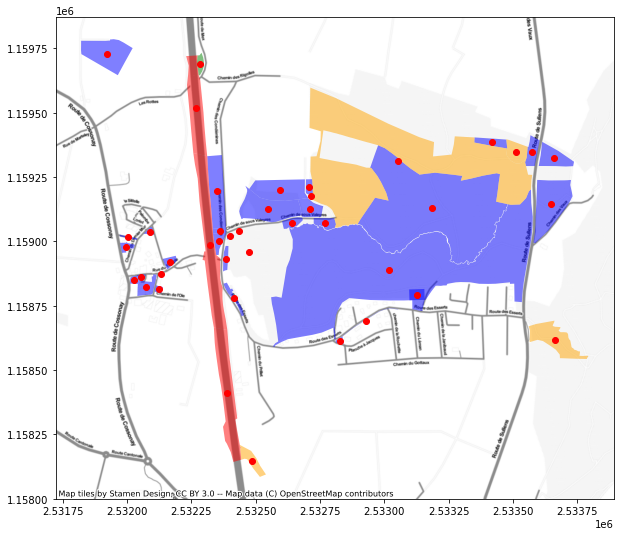

In [110]:
# Define layers

layers = []
layers.append({'layer' : 'com', 'geom' : whish_list.loc[whish_list['code_owner']==1], 'color' : 'blue'})
layers.append({'layer' : 'conf', 'geom' : whish_list.loc[whish_list['code_owner']==2], 'color' : 'red'})
layers.append({'layer' : 'etat', 'geom' : whish_list.loc[whish_list['code_owner']==3], 'color' : 'green'})
layers.append({'layer' : 'autre', 'geom' : whish_list.loc[whish_list['code_owner']==4], 'color' : 'orange'})

alpha_value = 0.5

fig, ax = plt.subplots(figsize=(10,10))
for row in layers:
    row['geom']['geometry'].plot(ax=ax, facecolor=row['color'], alpha=alpha_value)

whish_list['centroid'].plot(ax=ax, facecolor='red')
cx.add_basemap(ax=ax, crs=2056, source=cx.providers.Stamen.TonerLite)

#for x, y, label in zip(whish_list['centroid'].x, whish_list['centroid'].y, whish_list['fiche_id']):
#    plt.text(x, y, label, fontsize = 8)

# Export layers to shapefiles #

In [134]:
prefix_file_name = str(layers[0]['geom']['no_com'][0])

for row in layers:
    if not row['geom'].empty:
        gdf_tf = row['geom'][['no_com', 'no_parc', 'geometry']]
        gdf_tf.to_file("../data/" + prefix_file_name + "_" + row['layer'] + ".shp")
        
cent_tf = gpd.GeoDataFrame(whish_list[['fiche_id', 'centroid']])
cent_tf = cent_tf.rename(columns={"centroid": "geometry"})
cent_tf.to_file("../data/" + prefix_file_name + "_cent.shp")

# Export centroid to csv file #

In [ ]:
centroid = whish_list[['fiche_id', 'centroid']]

In [ ]:
centroid_file = open('../data/centroid.csv', 'w') 
for index, row in centroid.iterrows():
    if row['centroid'] is not None:
        v = "'" + str(row['fiche_id']) + "'," + str(round(row['centroid'].x, 3)) + "," + str(round(row['centroid'].y, 3)) + "\n"
        centroid_file.write(v)
centroid_file.close() 

-----

# Tests zone #